In [38]:
import sys
#sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')
#sys.path.insert(0, '/path/to/your/cloned/gcr-catalogs')
sys.path.insert(0, '../../gcr-catalogs')

from collections import defaultdict
import pandas as pd
import numpy as np
from astropy.table import Table
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
from GCR import GCRQuery
import GCRCatalogs

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
racenter = 55.
rawidth = 0.5
deccenter = -30.
decwidth = 0.09

ra_filter = GCRQuery('abs(ra - {}) < {}'.format(racenter, rawidth))
dec_filter = GCRQuery('abs(dec - {}) < {}'.format(deccenter, decwidth))

In [4]:
refCat = GCRCatalogs.load_catalog('dc2_reference_run1.1p')
coordinatesRefCat = refCat.get_quantities(['ra','dec'], filters=[ra_filter, dec_filter])

../../gcr-catalogs/GCRCatalogs/reference_catalog.py:59: UserWarning: genfromtxt: Empty input file: "<_io.BufferedReader name='/global/projecta/projectdirs/lsst/groups/SSim/DC2/reference_catalogs/dc2_reference_catalog_dc2v2.1.2.txt'>"
  data = np.genfromtxt(f, self._data_dtype, delimiter=',', max_rows=self._nlines)


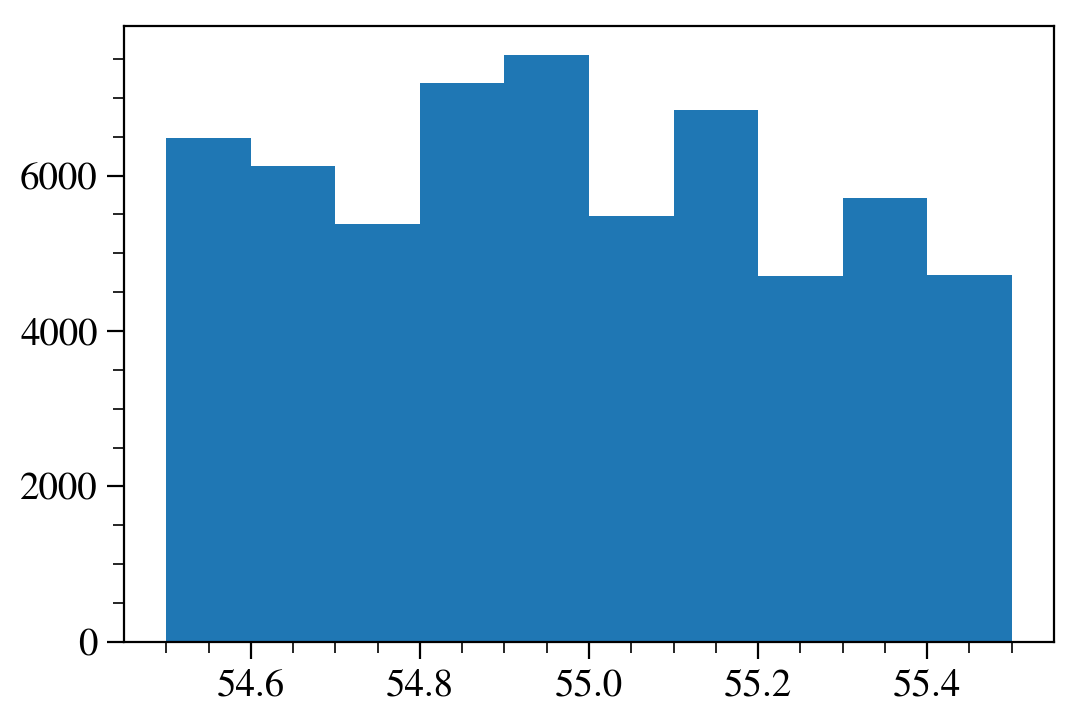

In [5]:
plt.hist(coordinatesRefCat['ra']);

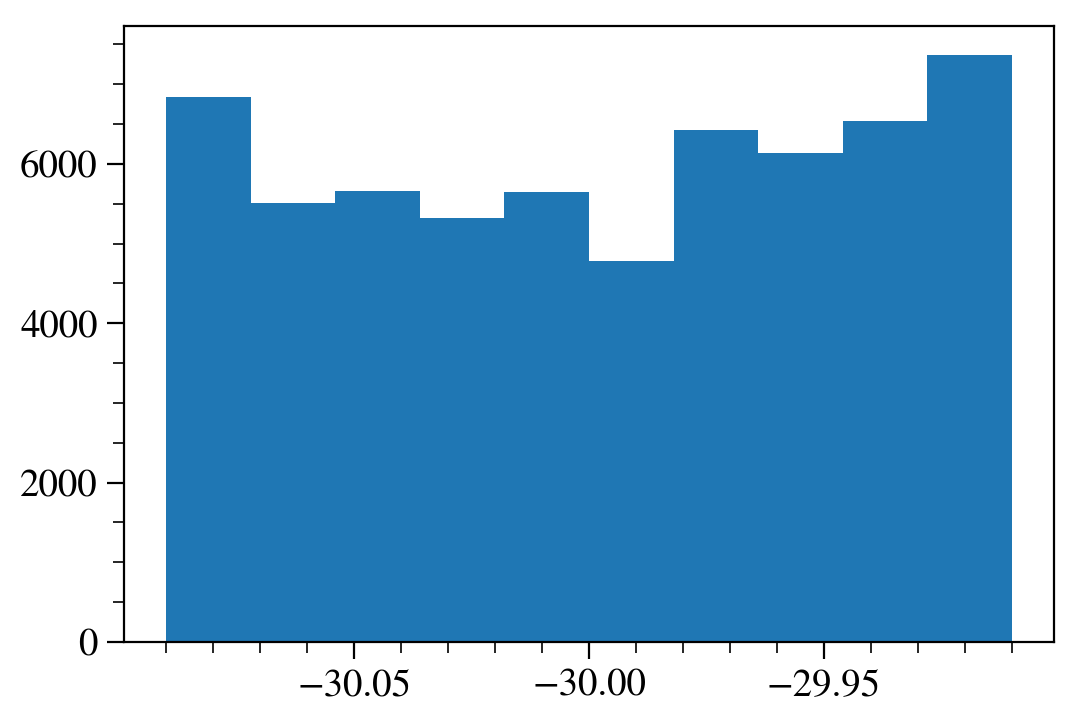

In [6]:
plt.hist(coordinatesRefCat['dec']);

In [7]:
coaddCat = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [8]:
tracts = list(coaddCat.available_tracts)
print(len(tracts))

19


In [9]:
coordinatesCoaddCat = coaddCat.get_quantities(['ra', 'dec'], filters=[ra_filter, dec_filter])

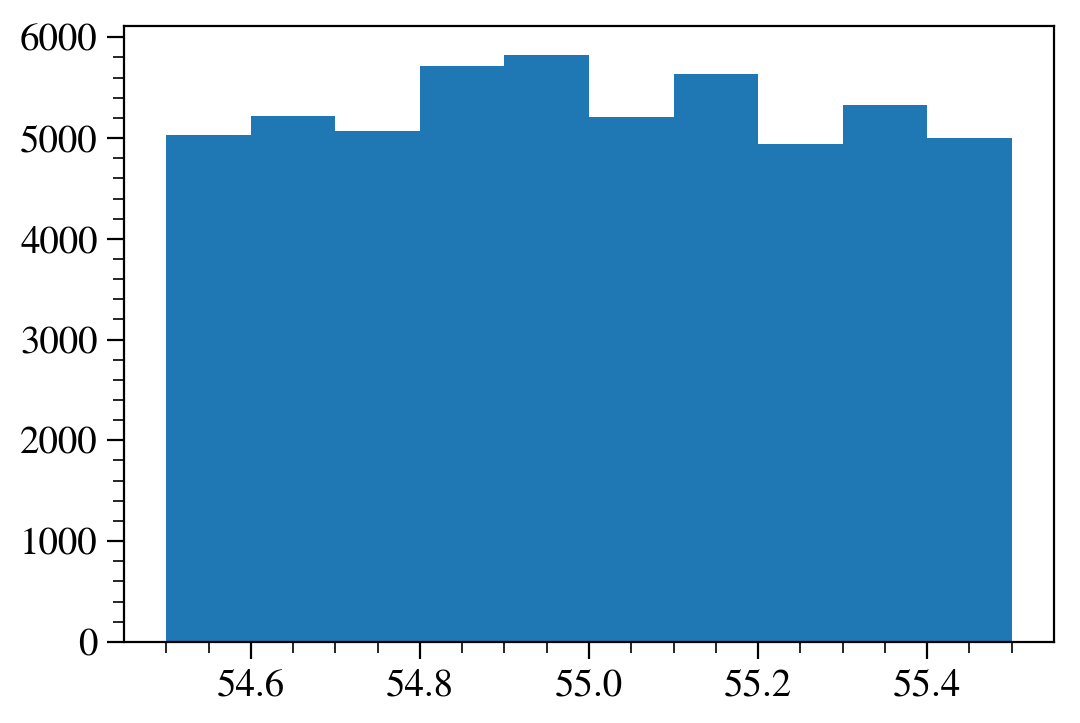

In [10]:
plt.hist(coordinatesCoaddCat['ra']);

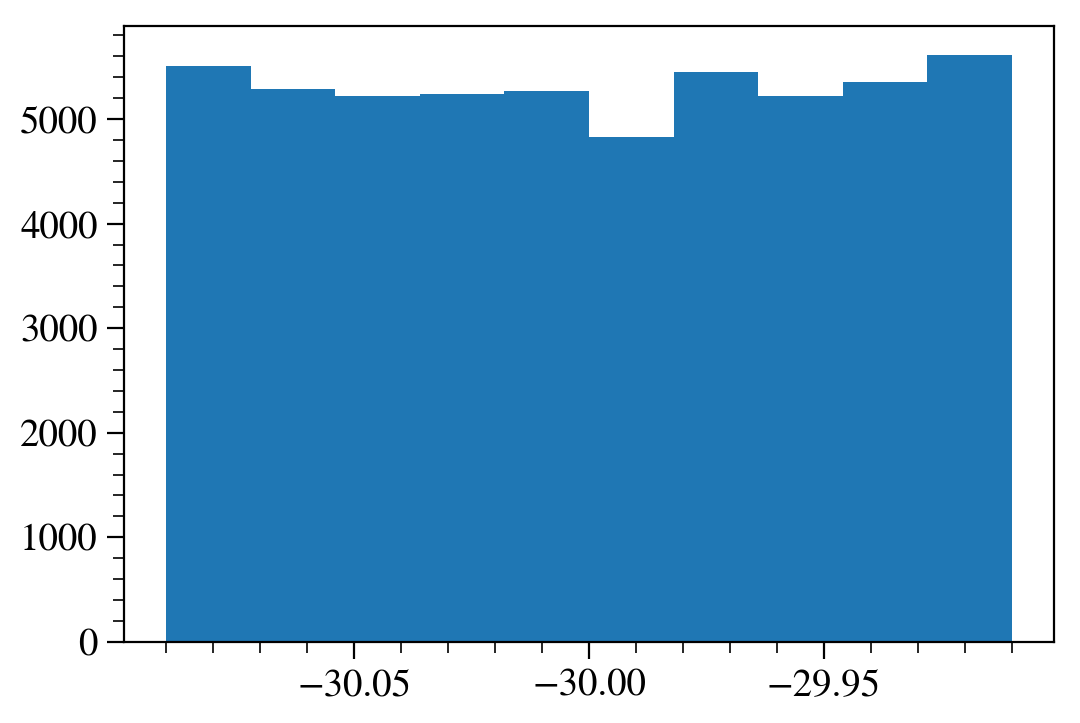

In [11]:
plt.hist(coordinatesCoaddCat['dec']);

In [12]:
results = FoFCatalogMatching.match({'ref' : Table(coordinatesRefCat), 'coadd' : Table(coordinatesCoaddCat)}, 1.0)

In [42]:
nMax = 10
hist2d = np.zeros((nMax,nMax))
inputNdx = defaultdict(list)
outputNdx = defaultdict(list)

for group in results.groups:
    ref_mask = group['catalog_key'] == 'ref'
    coadd_mask = group['catalog_key'] == 'coadd'
    
    Nin = np.count_nonzero(ref_mask)
    Nout = np.count_nonzero(coadd_mask)
    if Nin < nMax and Nout < nMax:
        hist2d[Nin, Nout] += 1
    
    key = (Nin, Nout)
    inputNdx[key].append(group['row_index'][ref_mask].data)
    outputNdx[key].append(group['row_index'][coadd_mask].data)
    
for key in inputNdx:
    inputNdx[key] = np.concatenate(inputNdx[key])
    outputNdx[key] = np.concatenate(outputNdx[key])

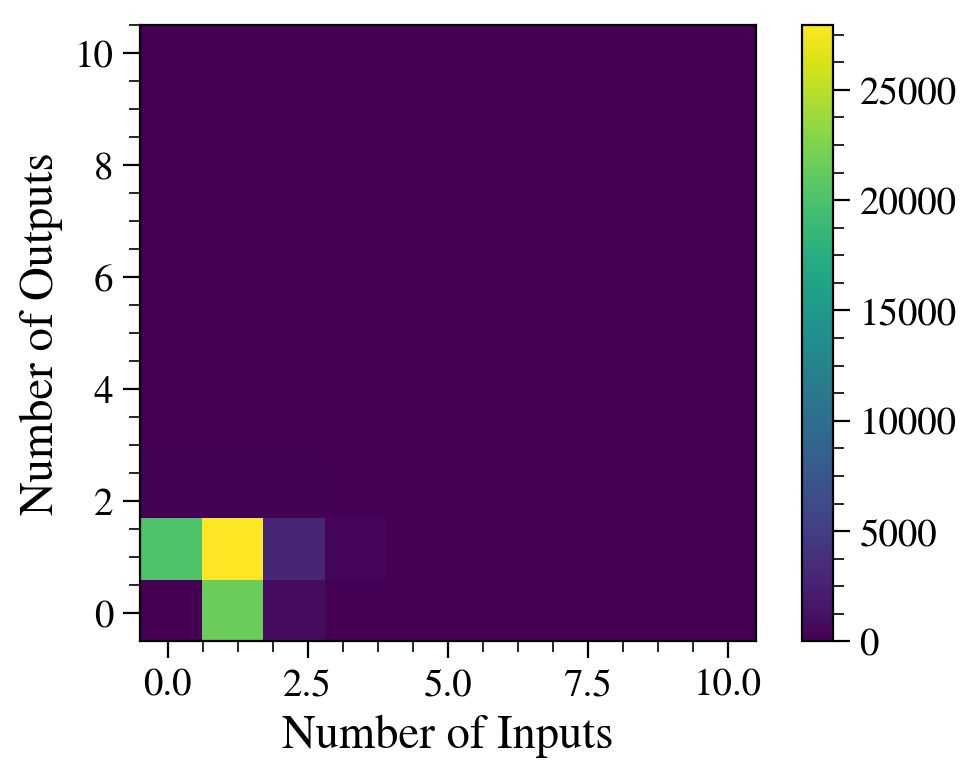

In [43]:
plt.imshow(hist2d.T, extent=(-0.5,nMax+0.5,-0.5,nMax+0.5),origin='lower')
plt.xlabel('Number of Inputs')
plt.ylabel('Number of Outputs')
plt.colorbar()
plt.savefig("#ItemsOutputs vs #ItemsInputs.png")
plt.show()

In [45]:
deltara = coordinatesRefCat['ra'][inputNdx[(1,1)]] - coordinatesCoaddCat['ra'][outputNdx[(1,1)]]
deltadec = coordinatesRefCat['dec'][inputNdx[(1,1)]] - coordinatesCoaddCat['dec'][outputNdx[(1,1)]]

ref_sc = SkyCoord(coordinatesRefCat['ra'][inputNdx[(1,1)]], coordinatesRefCat['dec'][inputNdx[(1,1)]], unit="deg")
coadd_sc = SkyCoord(coordinatesCoaddCat['ra'][outputNdx[(1,1)]], coordinatesCoaddCat['dec'][outputNdx[(1,1)]], unit="deg")
delta_arcsec = ref_sc.separation(ref_sc).arcsec

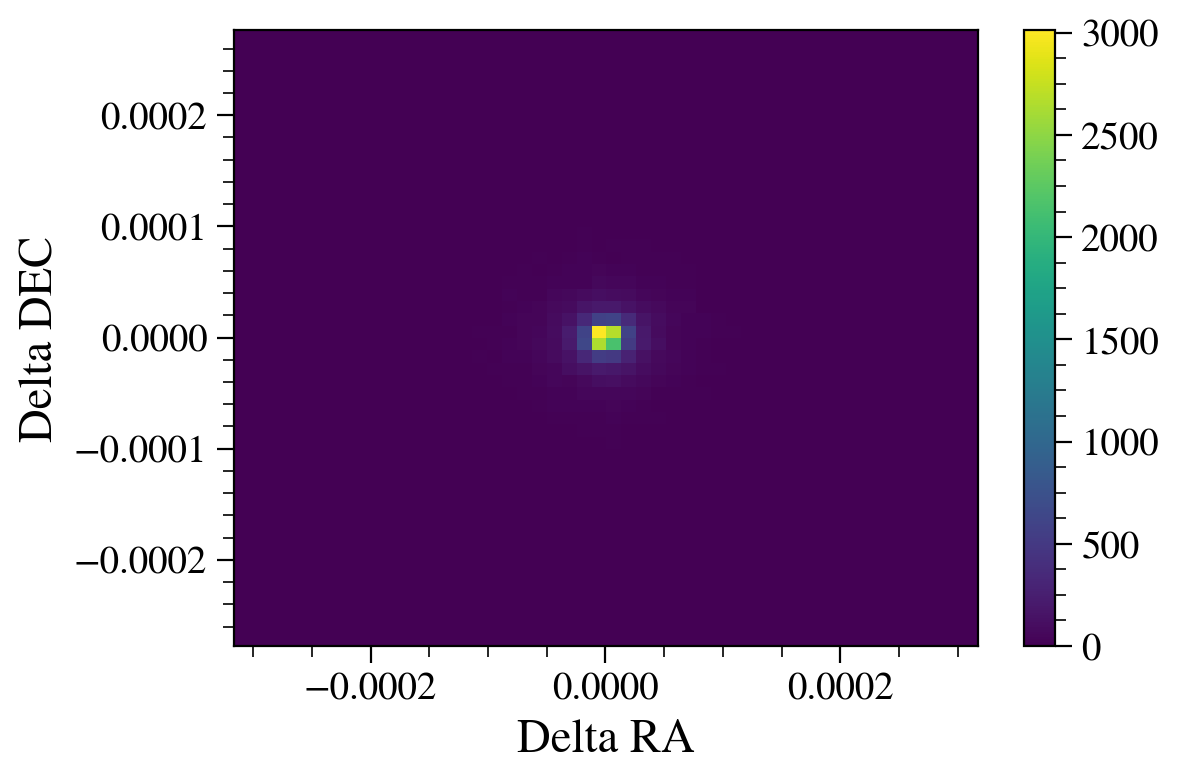

In [46]:
plt.hist2d(deltara, deltadec, bins=50)
plt.xlabel('Delta RA')
plt.ylabel('Delta DEC')
plt.colorbar()
plt.savefig("DeltaDECvsDeltaRA(non-logarithmic).png")
plt.show()

(0, 0.5)

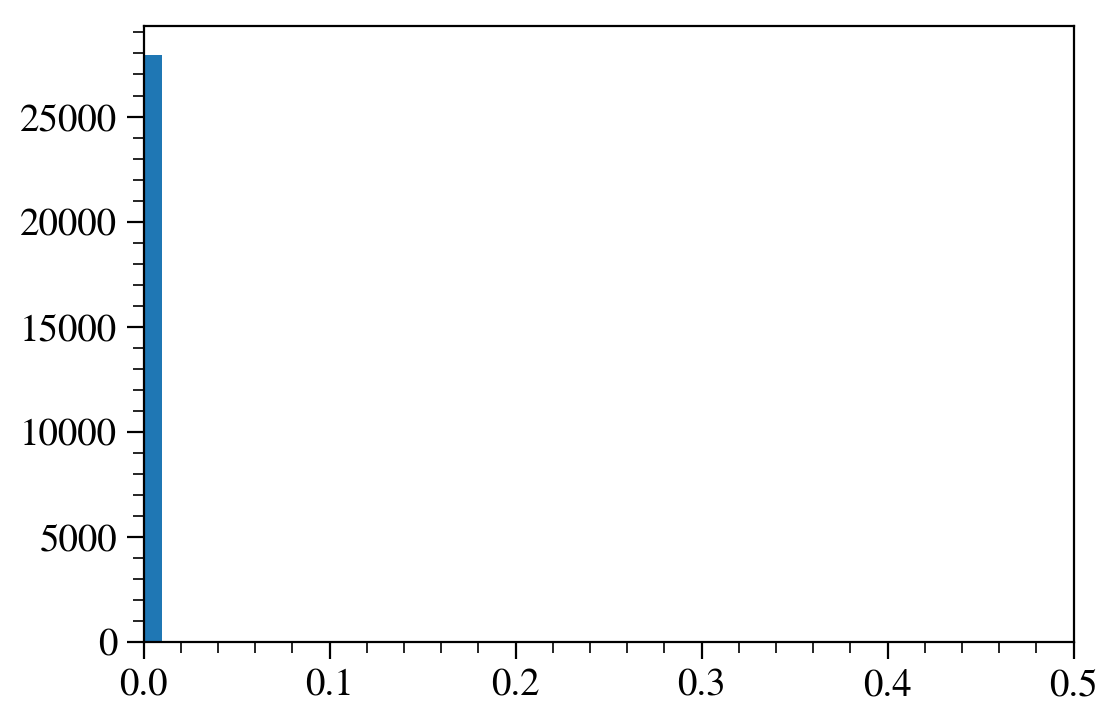

In [49]:
#Plotting Delta Phi for the outputs
plt.hist(delta_arcsec, bins=100);
plt.xlim(0, 0.5)